# <p style="background-color:#328ca9;font-family:newtimeroman;color:#102446;font-size:150%;text-align:center;border-radius:40px 40px;">Regression with Flood Prediction</p>

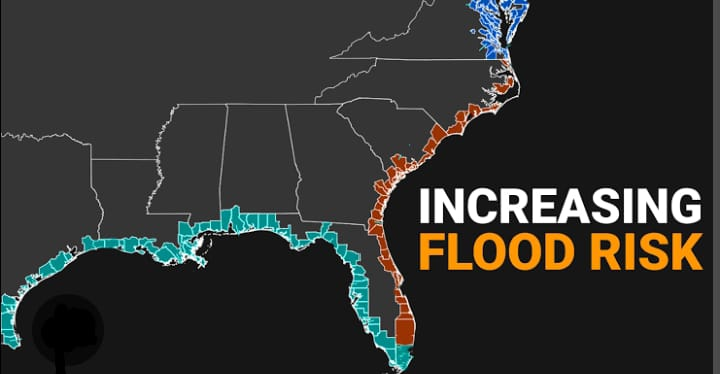

# <p style="background-color:#328ca9;font-family:newtimeroman;color:#102446;font-size:100%;text-align:center;border-radius:40px 40px;">Aims</p>

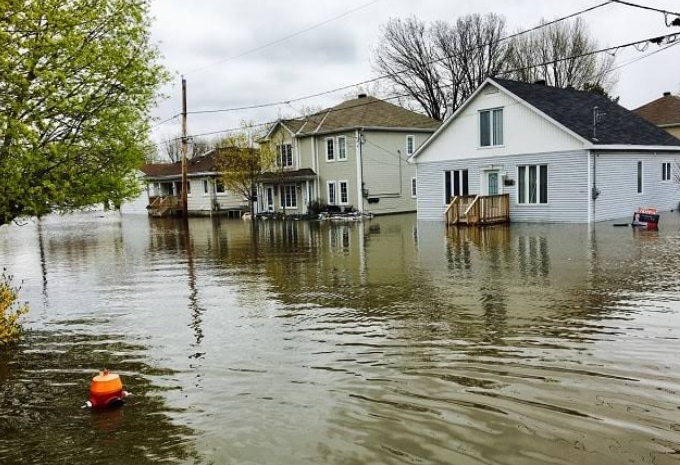

Basically, we hope to keep it simple by doing the following
1. Exploratory Data Analysis
2. Feature scaling
3. Model building, fitting and predicting
4. Hpyerparameter tuning

# <p style="background-color:#328ca9;font-family:newtimeroman;color:#102446;font-size:150%;text-align:center;border-radius:40px 40px;">Importing Libraries</p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Mathematical Libraries needed for DataFrame
#import numpy as np
#import pandas as pd
#pd.set_option('display.max_columns', None)

# Visualization Libraries
#import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('darkgrid')
#plt.style.use('dark_background')

# Remove unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Display DataFrames
#from IPython.display import display, display_html


#from sklearn.preprocessing import Imputer

warnings.filterwarnings("ignore")

# Read data and EDA

In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
train.head()

In [ ]:
train.shape

In [ ]:
df_test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
df_test.head()

In [ ]:
df_test.shape

In [ ]:
train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

# <p style="background-color:#328ca9;font-family:newtimeroman;color:#102446;font-size:150%;text-align:center;border-radius:40px 40px;">Exploratory Data Analysis</p>

In [ ]:
# check for null values

train.isna().sum()

In [ ]:
# check data type for each columns
train.info()

In [ ]:
train.describe().T

# Heatmap plot

In [ ]:
plt.figure(figsize=(14,12),dpi=200)
sns.set_style('ticks')
#cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)

#corr = df.corr(numeric_only=True)
corr = train.corr()
matrix = np.triu(corr)    # to mask the upper triangle

sns.heatmap(corr,mask=matrix, vmax=1, vmin=0.5, center=0.75, fmt='0.2f',cmap= 'cool',annot=True,linewidths=0.2,xticklabels=False)

plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.xticks(fontsize=8,fontweight='bold')
#plt.yticks(fontsize=8,fontweight='bold')


plt.show()

In [ ]:
# function to get high correlated features

def get_high_correlated_features(data, threshold1):
  data_corr = data.select_dtypes(exclude='object').corr()
  high_correlated_features = []
  for row in data_corr.columns:
    for col in data_corr.columns:
      if ((data_corr[row][col] > threshold1 or data_corr[row][col] < -threshold1) and row != col):
        high_correlated_features.append(row)

  return high_correlated_features

In [ ]:
get_high = get_high_correlated_features(train.drop(['FloodProbability'], axis=1), 0.5)
get_high

There are no correlated columns

In [ ]:
# Distribution of target column
plt.figure(figsize=(10, 4))
plt.hist(train.FloodProbability, bins=100)
plt.title("Distribution of Train data")
plt.show()

### Boxplot distribution

In [ ]:
def plot_numerics(data):
    numeric_columns = data.columns
    # Plotting histograms and box plots for each numeric column
    for column in numeric_columns:
        _, ax = plt.subplots(1,2, figsize=(16, 5))
        ax=ax.flatten()

        # Histogram
        sns.histplot(data[column], bins=50, kde=True, color='skyblue', ax=ax[0])
        ax[0].set_title(f'Histogram of {column}', fontsize=15,fontweight='bold')
        ax[0].set_xlabel(column, fontsize=12)
        ax[0].set_ylabel('Frequency', fontsize=12)

        # Box plot
        sns.boxplot(x=data[column], color='red', ax=ax[1])
        ax[1].set_title(f'Box plot of {column}', fontsize=15,fontweight='bold')
        ax[1].set_xlabel(column, fontsize=12)

        plt.tight_layout()
        plt.show()
        
def get_count_plot(cat):
    ax=sns.countplot(x=df_train[cat],
                   order=df_train[cat].value_counts(ascending=False).index);
        
    abs_values = df_train[cat].value_counts(ascending=False)
    rel_values = df_train[cat].value_counts(ascending=False, normalize=True).values * 100
    lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

    ax.bar_label(container=ax.containers[0], labels=lbls)
    ax.set_title("Distribution of "+cat+" Values",fontsize=16)

In [ ]:
num_cols=['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors']

In [ ]:
plot_numerics(train[num_cols])

In [ ]:
#new_df = remove_outliers(train, num_cols)

In [ ]:
#plot_numerics(new_df[num_cols])

# <p style="background-color:#328ca9;font-family:newtimeroman;color:#102446;font-size:150%;text-align:center;border-radius:40px 40px;">Model Building</p>

### Split the dataset 

In [ ]:
# Create a feature and target variable
X = train.drop('FloodProbability', axis=1) # Feature
y = train['FloodProbability'] # Target


In [ ]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#scaler = StandardScaler()
#X_train_scale = scaler.fit_transform(X_train)
#X_test_scale = scaler.transform(X_test)

### Build Baseline XGB

In [ ]:
# fit a model with default parameters
xgb_model = XGBRegressor()

#rgr = DecisionTreeRegressor()
xgb_model.fit(X_train,y_train)

# compute performance on test set
y_pred = xgb_model.predict(X_test)
print('r2 score: %.2f' % r2_score(y_test,y_pred))
print('mse score: %.2f' % mean_squared_error(y_test,y_pred))
print('mae score: %.2f' % mean_absolute_error(y_test,y_pred))

# <p style="background-color:#328ca9;font-family:newtimeroman;color:#102446;font-size:150%;text-align:center;border-radius:40px 40px;">Model Improvement</p>

### Feature Engineering

In [ ]:
# create a function for more features
def getFeats(df):
    
#    scaler = StandardScaler()
    
    df['total'] = df[num_cols].sum(axis=1)
    df['sum'] = (df[num_cols] ** 1.5).sum(axis=1)
    df['mean'] = df[num_cols].mean(axis=1)
    df['median'] = df[num_cols].median(axis=1)
    df['max'] = df[num_cols].max(axis=1)
    df['min'] = df[num_cols].min(axis=1)
    df['fkurtosis'] = df[num_cols].kurtosis(axis=1)
    df['quant25'] = df[num_cols].quantile(0.25, axis=1)
    df['quant75'] = df[num_cols].quantile(0.75, axis=1)
    
#    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    return df

In [ ]:
new_train = getFeats(train)
new_train.shape

In [ ]:
# Create a feature and target variable for new dataframe
new_X = new_train.drop('FloodProbability', axis=1) # Feature
new_y = new_train['FloodProbability'] # Target


In [ ]:
# Train Test Split
#from sklearn.model_selection import train_test_split

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=42)

In [ ]:
# fit a model with default parameters
new_xgb_model = XGBRegressor()

#rgr = DecisionTreeRegressor()
new_xgb_model.fit(new_X_train,new_y_train)

# compute performance on test set
new_y_pred = new_xgb_model.predict(new_X_test)
print('r2 score: %.2f' % r2_score(new_y_test,new_y_pred))
print('mse score: %.2f' % mean_squared_error(new_y_test,new_y_pred))
print('mae score: %.2f' % mean_absolute_error(new_y_test,new_y_pred))

# Hyperparameters tuning

In [ ]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
#Run only in the first run of the kernel.
#hyperParameterTuning(new_X_train, new_y_train)

### Best params

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'sub_sample': 0.5}

# Best fit

In [ ]:
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.01,
        max_depth = 10,
        min_child_weight = 5,
        n_estimators = 500,
        subsample = 0.5)

%time xgb_model.fit(new_X_train, new_y_train, eval_set=[(new_X_test, new_y_test)], verbose=False)

y_pred_xgb = xgb_model.predict(new_X_test)

new_r2_xgb = r2_score(new_y_test, y_pred_xgb)

print("r2_score_score: ", new_r2_xgb)

# Add more features to test data

In [ ]:
new_df_test = getFeats(df_test)
new_df_test.shape

In [ ]:
new_df_test.head()

In [ ]:
pred = xgb_model.predict(new_df_test)

### Submit

In [ ]:
#sub.to_csv('submission.csv', index=False)

In [ ]:
sub_data = pd.read_csv('/kaggle/input/sample-submissiom/sample_submission.csv')

In [ ]:
 sub_data.keys()


In [ ]:
id = sub_data['id']


In [ ]:
submission = pd.DataFrame({'id':id, 'FloodProbability': pred})
submission.to_csv('submission.csv', index=False)


In [ ]:
submission

## Reference

1. https://www.kaggle.com/code/zeyadsayedadbullah/flood-forecasting-with-xgboost

2. https://www.kaggle.com/code/aspillai/flood-prediction-regression-lightgbm-0-86891?scriptVersionId=177699435

In [ ]:
#cv = KFold(5, shuffle=True, random_state=0)
#cv_splits = cv.split(X_train, y_train)
#scores = list()
#model = LGBMRegressor(objective='regression', random_state=0, device='gpu', verbosity = -1,)
#for train_idx, val_idx in cv_splits:
#    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
#    model.fit(X_train_fold, y_train_fold)
#    y_pred = model.predict(X_val_fold)
#    r2 = r2_score(y_val_fold, y_pred)
#    scores.append(r2)
    
#print(f'Mean R2 score: {np.mean(scores):.5f}')

In [ ]:
#optimize = False
#def objective(trial):
#    params = {
#        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
#        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
#        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
#        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
#        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
#        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
#        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
#        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
#        'max_depth': trial.suggest_int('max_depth', 1, 15)
#    }
#    cv = KFold(5, shuffle=True, random_state=0)
#    cv_splits = cv.split(X_train, y_train)
#    scores = list()

#    for train_idx, val_idx in cv_splits:
#        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
#        model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity = -1,)
#        model.fit(X_train_fold, y_train_fold)
        
#        y_pred = model.predict(X_val_fold)
#        r2 = r2_score(y_val_fold, y_pred)
#        scores.append(r2)
        
#    return np.mean(scores)
    

#sqlite_db = "sqlite:///lgbm1.db"
#study_name = "lgbm"

#if optimize:
#    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
#                                sampler=TPESampler(n_startup_trials=75, multivariate=True, seed=0),
#                                direction="maximize", load_if_exists=True)

#    study.optimize(objective, n_trials=200)
#    print(f"best optimized accuracy: {study.best_value:0.5f}")
#    print(f"best hyperparameters: {study.best_params}")

#    lgbm_params = study.best_params
#else: 
#    lgbm_params = {
#        'num_leaves': 183, 
#        'learning_rate': 0.01183688880802108, 
#        'n_estimators': 577, 
#        'subsample_for_bin': 165697, 
#        'min_child_samples': 114, 
#        'reg_alpha': 2.075080888948164e-06, 
#        'reg_lambda': 3.838938366471552e-07, 
#        'colsample_bytree': 0.9634044234652241, 
#        'subsample': 0.9592138618622019, 
#        'max_depth': 9
##    }#

# Submission

In [ ]:
#cv = KFold(5, shuffle=True, random_state=0)
#cv_splits = cv.split(X_train, y_train)
#scores = list()
#test_preds = list()
#model = LGBMRegressor(**lgbm_params, objective='regression', random_state=0, device='gpu', verbosity = -1,)
#for train_idx, val_idx in cv_splits:
#    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
#    model.fit(X_train_fold, y_train_fold)
#    y_val_prob = model.predict(X_val_fold)
#    r2 = r2_score(y_val_fold, y_val_prob)
#    scores.append(r2)
#    y_pred = model.predict(X_test)
#    test_preds.append(y_pred)
    
#print(f'Mean R2 score: {np.mean(scores):.5f}')

In [ ]:
#sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')
#sample_submission['FloodProbability'] = np.mean(test_preds, axis=0)
#sample_submission.to_csv('submission.csv', index=False)
#sample_submission.head()